In [1]:
import os
from collections import deque
from argparse import Namespace
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
os.chdir('..')
from sidegame.game.client import SDGReplayClient
from sidegame.audio import spectrify

### Demo initialisation

In [3]:
args = Namespace()
args.seed = 42
args.recording_path = 'user_data/dem0_demo-60.0_000.sdg'
args.logging_path = None
args.logging_level = 10
args.show_fps = False
args.volume = 1.
args.render_scale = 3

In [4]:
def show_obs(sdgr: SDGReplayClient):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

    ax1.imshow(sdgr.video_stream.popleft()[..., ::-1])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Video frame')

    spectrum = spectrify(sdgr.audio_stream.popleft(), eps=1e-5)
    left, right = spectrum

    ax2.plot(left, label='Left ear')
    ax2.plot(right, label='Right ear')
    ax2.set_xlabel('Mel freq. point')
    ax2.set_ylabel('Power [dB]')
    ax2.set_title('Audio spectrum slice')
    ax2.grid()
    ax2.legend()
    
    sdgr.action_stream.clear()

    return spectrum

In [5]:
sdgr = SDGReplayClient(args, headless=True)

2021-05-19 21:46:48,678 - ReplayClient - DEBUG - Replay data loaded.


### Observations

Null at the start

In [6]:
sdgr.video_stream, sdgr.audio_stream

(deque([]), deque([]))

Frame, but no audio at the beginning

In [7]:
clk = None

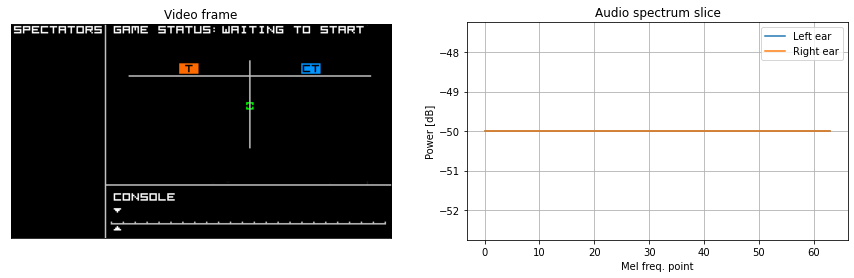

In [8]:
clk = sdgr.manual_step(clk)
show_obs(sdgr);

Some audio after gunfire

In [9]:
clk = sdgr.jump_to_timestamp(clk, 40.8)

sdgr.video_stream.clear()
sdgr.audio_stream.clear()
sdgr.action_stream.clear()

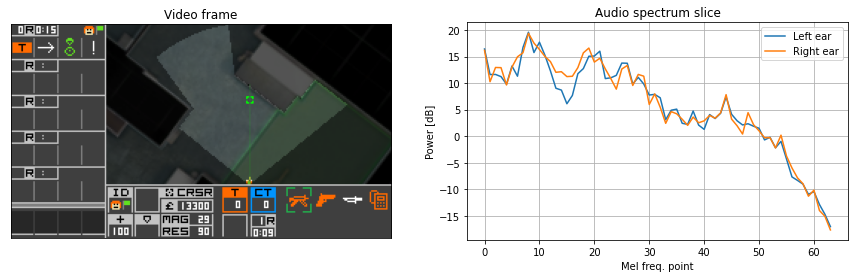

In [10]:
clk = sdgr.manual_step(clk)
show_obs(sdgr);

### Game state

In [11]:
clk = sdgr.jump_to_timestamp(clk, 110.)

sdgr.video_stream.clear()
sdgr.audio_stream.clear()
sdgr.action_stream.clear()

#### Statistics

In [12]:
sdgr.stats.summary()

[('kills', 0),
 ('deaths', 0),
 ('assists', 0),
 ('kill_death_ratio', 0.0),
 ('kdassist_ratio', 0.0),
 ('kills_per_round', 0.0),
 ('deaths_per_round', 0.0),
 ('assists_per_round', 0.0),
 ('avg_damage_per_round', 0.0),
 ('multikills_per_round', 0.0),
 ('average_multikills', 0.0),
 ('util_dmg_per_throw', 0.0),
 ('util_throws_per_round', 0.0),
 ('money_spent_per_kill', 2700.0),
 ('distance_per_kill', 1236.1982279926285),
 ('average_speed', 15.694938467449743),
 ('noise_steps_per_round', 95.0),
 ('health_at_round_end', 0.0),
 ('messages_per_round', 2.0),
 ('opening_success', 0.0),
 ('clutch_success', 0.0),
 ('kill_assist_survival_trade', 0.0),
 ('impact', -0.41),
 ('rating_2', 0.061448000000000016),
 ('round_win_share', 0.0),
 ('success_take', 0.0),
 ('success_afterplant', 0.0),
 ('success_t_side', 0.0),
 ('success_hold', 0.0),
 ('success_retake', 0.0),
 ('success_ct_side', 0.0)]

#### Heatmap of covered positions

In [13]:
wallmap = cv2.imread('sidegame/assets/maps/de_cache_code.png', cv2.IMREAD_COLOR)[..., 1]
wallmap = cv2.resize(wallmap, (64, 64), cv2.INTER_AREA)
wallmap = np.where(wallmap == 255, 1., 0.)

In [14]:
sdgr.stats.tracked_heatmap.max()

5.8318939208984375

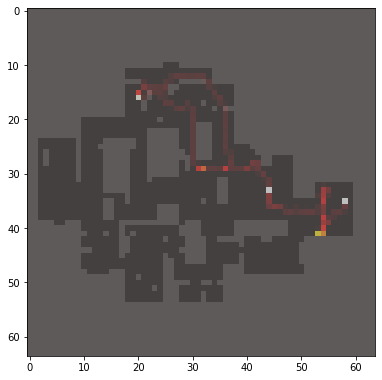

In [15]:
plt.figure(figsize=(6.4, 6.4))
plt.imshow(wallmap, cmap='gray', vmin=-2.5, vmax=2.5)
plt.imshow(sdgr.stats.tracked_heatmap, cmap='hot', vmin=0., vmax=5., alpha=0.5);

### Spectrum assembly

In [16]:
clk = sdgr.jump_to_timestamp(clk, 37.)

sdgr.video_stream.clear()
sdgr.audio_stream.clear()
sdgr.action_stream.clear()

In [17]:
# Accumulate spectral vectors at each step for the next 11 seconds
spectrum = deque()

for _ in range(60*11):
    clk = sdgr.manual_step(clk)
    spectrum.append(spectrify(sdgr.audio_stream.popleft(), eps=1e-5))
    
    sdgr.video_stream.clear()
    sdgr.action_stream.clear()
    
spectrum = np.array(spectrum)

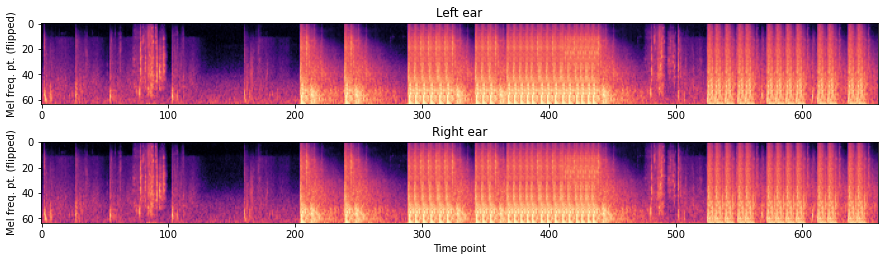

In [18]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 4))
ax1.imshow(spectrum[:, 0, ::-1].T, cmap='magma')
ax1.set_ylabel('Mel freq. pt. (flipped)')
ax1.set_title('Left ear')

ax2.imshow(spectrum[:, 1, ::-1].T, cmap='magma')
ax2.set_ylabel('Mel freq. pt. (flipped)')
ax2.set_xlabel('Time point')
ax2.set_title('Right ear');

Note: There is a notable difference between the sounds of walking (left), the rifle (centre), and the pistol (right).

In [19]:
sdgr.cleanup()